In [23]:
import os
import cv2
import sys
import math
import glob
import openslide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# for test data
path0 = './Data/test'
plist = np.sort(glob.glob(path0+'/*.mrxs'))

for pn in plist:
    test_pid = pn.split('.mrxs')[0].split('/')[-1]
    test_sl = openslide.OpenSlide(pn)
    break

In [25]:
test_lv = test_sl.level_count
test_mx = int(test_sl.properties['mirax.GENERAL.OBJECTIVE_MAGNIFICATION'])  

test_shape = test_sl.level_dimensions[0]

# MPP, Micron Per Pixel
# 픽셀 당 얼마의 micrometer 가 담기느냐를 나타내는 수치
test_mpp = test_sl.properties.get('openslide.mpp-x')

print(f'For file             :: {test_pid}')
print(f'Level count          :: {test_lv}')
print(f'Image size per level :: {test_shape}')
print(f'Level 0 MPP          :: {test_mpp}')
print(f'Resolution           :: {test_mx}')

For file             :: image_001
Level count          :: 11
Image size per level :: (56462, 132956)
Level 0 MPP          :: 0.38895027624309397
Resolution           :: 20


In [ ]:
#for more informations
print(test_sl.properties)

In [26]:
def find_nearest_po2(n:float)->int:
    '''
    The function to find the nearest power of 2
    '''
    if (n&(n-1))!=0:
        n = math.ceil(n)
        dlth = len(bin(n))
        dmin = int('0b1'+'0'*(dlth-3), 2)
        dmax = int('0b1'+'0'*(dlth-2), 2)
        
        if(abs(n-dmin) > abs(dmax-n)):
            dr = dmax
        elif(abs(n-dmin) < abs(dmax-n)):
            dr = dmin
        elif(abs(n-dmin) == abs(dmax-n)):
            warn_message = 'Since there are two answers exist, the small one was returned.' 
            dr = dmin
            
        return dr
        
    else:
        n = int(n)
        
        return n

In [27]:
test_dims = [*test_sl.level_dimensions]
test_mags = []
test_ress = []
test_mpps = []

abs_mpp = {
#     Dict for calculate absolute MPPs
#     --------------------------------
#     keys : Resolutions (X)
#     values : MPPs 
    40 : 0.25,
    20 : 0.5,
    10 : 1,
    5 : 2,
    2.5 : 4,
}

test_mx = int(test_sl.properties['mirax.GENERAL.OBJECTIVE_MAGNIFICATION'])

if test_mx in abs_mpp:
    # Part to check when an error occurs
    dmx = abs_mpp[test_mx]
    for i in range(test_sl.level_count):
        r = test_dims[0][0]//test_dims[i][0]
        r = find_nearest_po2(r)
        test_mags.append(r)
        test_ress.append(test_mx/r)
        test_mpps.append(dmx*r)
else:
    raise Exception("Need to adjust the manification manually!")

In [28]:
test_df = pd.DataFrame(
    [test_dims,test_mags,test_ress,test_mpps],
    index = ['Size', 'Magnification','Resolution (X)','Micron Per Pixel'],
)
test_df

,0,1,2,3,4,5,6,7,8,9,10
Size,"(56462, 132956)","(28231, 66478)","(14115, 33239)","(7057, 16619)","(3528, 8309)","(1764, 4154)","(882, 2077)","(441, 1038)","(220, 519)","(110, 259)","(55, 129)"
Magnification,1,2,4,8,16,32,64,128,256,512,1024
Resolution (X),20.0,10.0,5.0,2.5,1.25,0.625,0.3125,0.15625,0.078125,0.039062,0.019531
Micron Per Pixel,0.5,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0


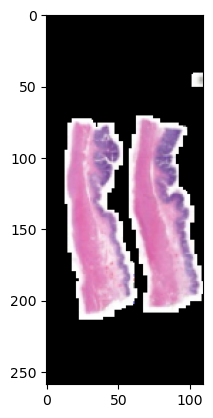

Sample size : 85470


In [29]:
# show entire sample
sample_level = 9

imgs = test_sl.read_region((0,0),sample_level,test_dims[sample_level]).convert('RGB')
imgs = np.array(imgs)
plt.imshow(imgs)
plt.show()
print(f'Sample size : {imgs.size}')

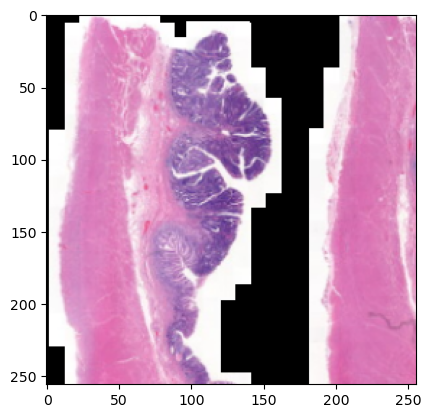

Sample size : (256, 256)


In [30]:
# show sample patch
patch_location_fl = (100,600)
patch_level = 7
patch_size = (256,256)

patch_location = (
    int(patch_location_fl[0]*test_mpps[patch_level]),
    int(patch_location_fl[1]*test_mpps[patch_level]),
)
imgs = test_sl.read_region(patch_location, 7, patch_size).convert('RGB')
plt.imshow(imgs)
plt.show()

print(f'Sample size : {imgs.size}')

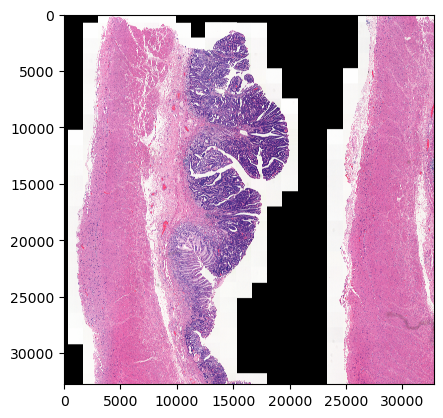

Sample size : (32768, 32768)


In [31]:
# show sample patch
patch_location_fl = (100,600)
patch_level = 7
patch_size = (256,256)

patch_location = (
    int(patch_location_fl[0]*test_mpps[patch_level]),
    int(patch_location_fl[1]*test_mpps[patch_level]),
)
patch_size = (
    int(patch_size[0]*test_mpps[patch_level+1]),
    int(patch_size[1]*test_mpps[patch_level+1]),
)
imgs = test_sl.read_region(patch_location, 0, patch_size).convert('RGB')
plt.imshow(imgs)
plt.show()

print(f'Sample size : {imgs.size}')